In [15]:
from Functions import *
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
from skfda.preprocessing.missing import MissingValuesInterpolation

In [34]:
data_tpts, data_x, data_y = data_deal()
data_x.columns = ['Mod', 'AS','A/T', r'$\text{FD}_{\text{Si}}$', 'LRS', 'MDa', 'MDb', 'MDc', 'Mdi', 'CD', 'CS', 'RT', 'WHSV']

Data processing completed!


## Define MBR_XGB model

In [35]:
class MBR_XGB:
    def __init__(self, data_tpts, n_basis, order):
        self.data_tpts = data_tpts
        self.n_basis = n_basis
        self.order = order
        self.model = None
    def fit(self, data_x, data_y, model_params,
            num_rounds=200, loss_type=1,
            silent=False):
        data_tpts = self.data_tpts
        n_basis = self.n_basis
        order = self.order
        loss_result = {'loss': []}
        global_init(data_tpts, n_basis, order)
        data_y_f = skfda.FDataGrid(
            data_matrix=data_y,
            grid_points=data_tpts)
        basis = BSplineBasis(
            n_basis=n_basis,
            order=order)
        basis_y = data_y_f.to_basis(basis)
        
        indices = np.arange(data_x.shape[0])
        dtrain_c = pd.DataFrame(basis_y.coefficients)
        dtrain_y = data_y
        X_train = data_x
        self.columns=list(X_train.columns)
        model_list = []
        dtrain_list = []
        for i in range(n_basis):
            dtrain = xgb.DMatrix(X_train, label=dtrain_c[i], feature_names=list(X_train.columns))
            dtrain_list.append(dtrain)
            model = xgb.Booster(model_params, [dtrain_list[i]])
            model_list.append(model)
            
        for _ in range(num_rounds):
            pred_total = pd.DataFrame()
            for i in range(n_basis):
                model = model_list[i]
                pred = model.predict(dtrain_list[i])
                pred_total[i] = pred
            g, h = hit_grads(pred_total, dtrain_y, dtrain_c, loss_type=loss_type)
            for i in range(n_basis):
                grad = g[:][i].to_numpy().flatten()
                hess = h[:][i].to_numpy().flatten()
                model = model_list[i]
                model.boost(dtrain_list[i], grad, hess)
                model_list[i] = model
            self.model = model_list
            self.dtrain_y = dtrain_y
            return {'model':model_list, 
                    'loss_result': loss_result}

    def evaluate(self, X, Y):
        data_tpts = self.data_tpts
        n_basis = self.n_basis
        order = self.order
        for i in range(n_basis):
            dtrain = xgb.DMatrix(X)
            dtrain_list.append(dtrain)
        c_pred = np.array([model.predict(dtrain_list[i]) for i, model in enumerate(self.model)]).T
        basis = BSplineBasis(
            domain_range=(0.0, data_tpts[-1]),
            n_basis=n_basis,
            order=order)
        pred_b = FDataBasis(basis, c_pred)
        pred_y = pred_b.to_grid(data_tpts).data_matrix
        pred_y = pred_y.reshape(-1,len((pred_y[0])))
        pred_y_df = pd.DataFrame(pred_y,columns=Y.columns)
        y_test_obs = Y
        numerator = np.nansum((y_test_obs - pred_y_df)**2)
        denominator = np.nansum((y_test_obs - np.nanmean(y_test_obs))**2)
        R2_score = 1 - (numerator / denominator)
        mise_score = np.nanmean(np.nansum((y_test_obs - pred_y_df)**2, axis=1))
        return{'R2':R2_score, 'mise':mise_score}
        
    def predict(self, X):
        X_DM = xgb.DMatrix(X, feature_names=self.columns)
        data_tpts = self.data_tpts
        n_basis = self.n_basis
        order = self.order
        c_pred = np.array([model.predict(X_DM) for i, model in enumerate(self.model)]).T
        basis = BSplineBasis(
            domain_range = (0.0, data_tpts[-1]),
            n_basis = n_basis,
            order = order)
        pred_b = FDataBasis(basis, c_pred)
        pred_y = pred_b.to_grid(data_tpts).data_matrix

        pred_y = pred_y.reshape(-1,len((pred_y[0])))
        pred_y_df = pd.DataFrame(pred_y,columns=self.dtrain_y.columns)
        return pred_y_df.values
        
    def predict_m(self, X):
        X_DM = xgb.DMatrix(X, feature_names=self.columns)
        data_tpts = self.data_tpts
        n_basis = self.n_basis
        order = self.order
        c_pred = np.array([model.predict(X_DM) for i, model in enumerate(self.model)]).T
        basis = BSplineBasis(
            domain_range = (0.0, data_tpts[-1]),
            n_basis = n_basis,
            order = order)
        pred_b = FDataBasis(basis, c_pred)
        pred_y = pred_b.to_grid(data_tpts).data_matrix
        pred_y = pred_y.reshape(-1,len((pred_y[0])))
        return np.mean(pred_y,axis=1)


In [36]:
MBR_XGB = MBR_XGB(data_tpts=data_tpts,n_basis=4,order=3)

In [37]:
model_params = {'eta': 0.1,
        'max_depth':6,
        'objective': 'reg:squarederror'}
out_put = MBR_XGB.fit(data_x = data_x, data_y = data_y, model_params = model_params,
            num_rounds=200, loss_type=1, silent=False)
mbr_xgb_model = out_put['model']

In [38]:
import shap
shap.initjs()
explainer = shap.KernelExplainer(model=MBR_XGB.predict_m, data=data_x, link="identity")
shap_values = explainer.shap_values(X=data_x, nsamples=100)

  0%|          | 0/97 [00:00<?, ?it/s]

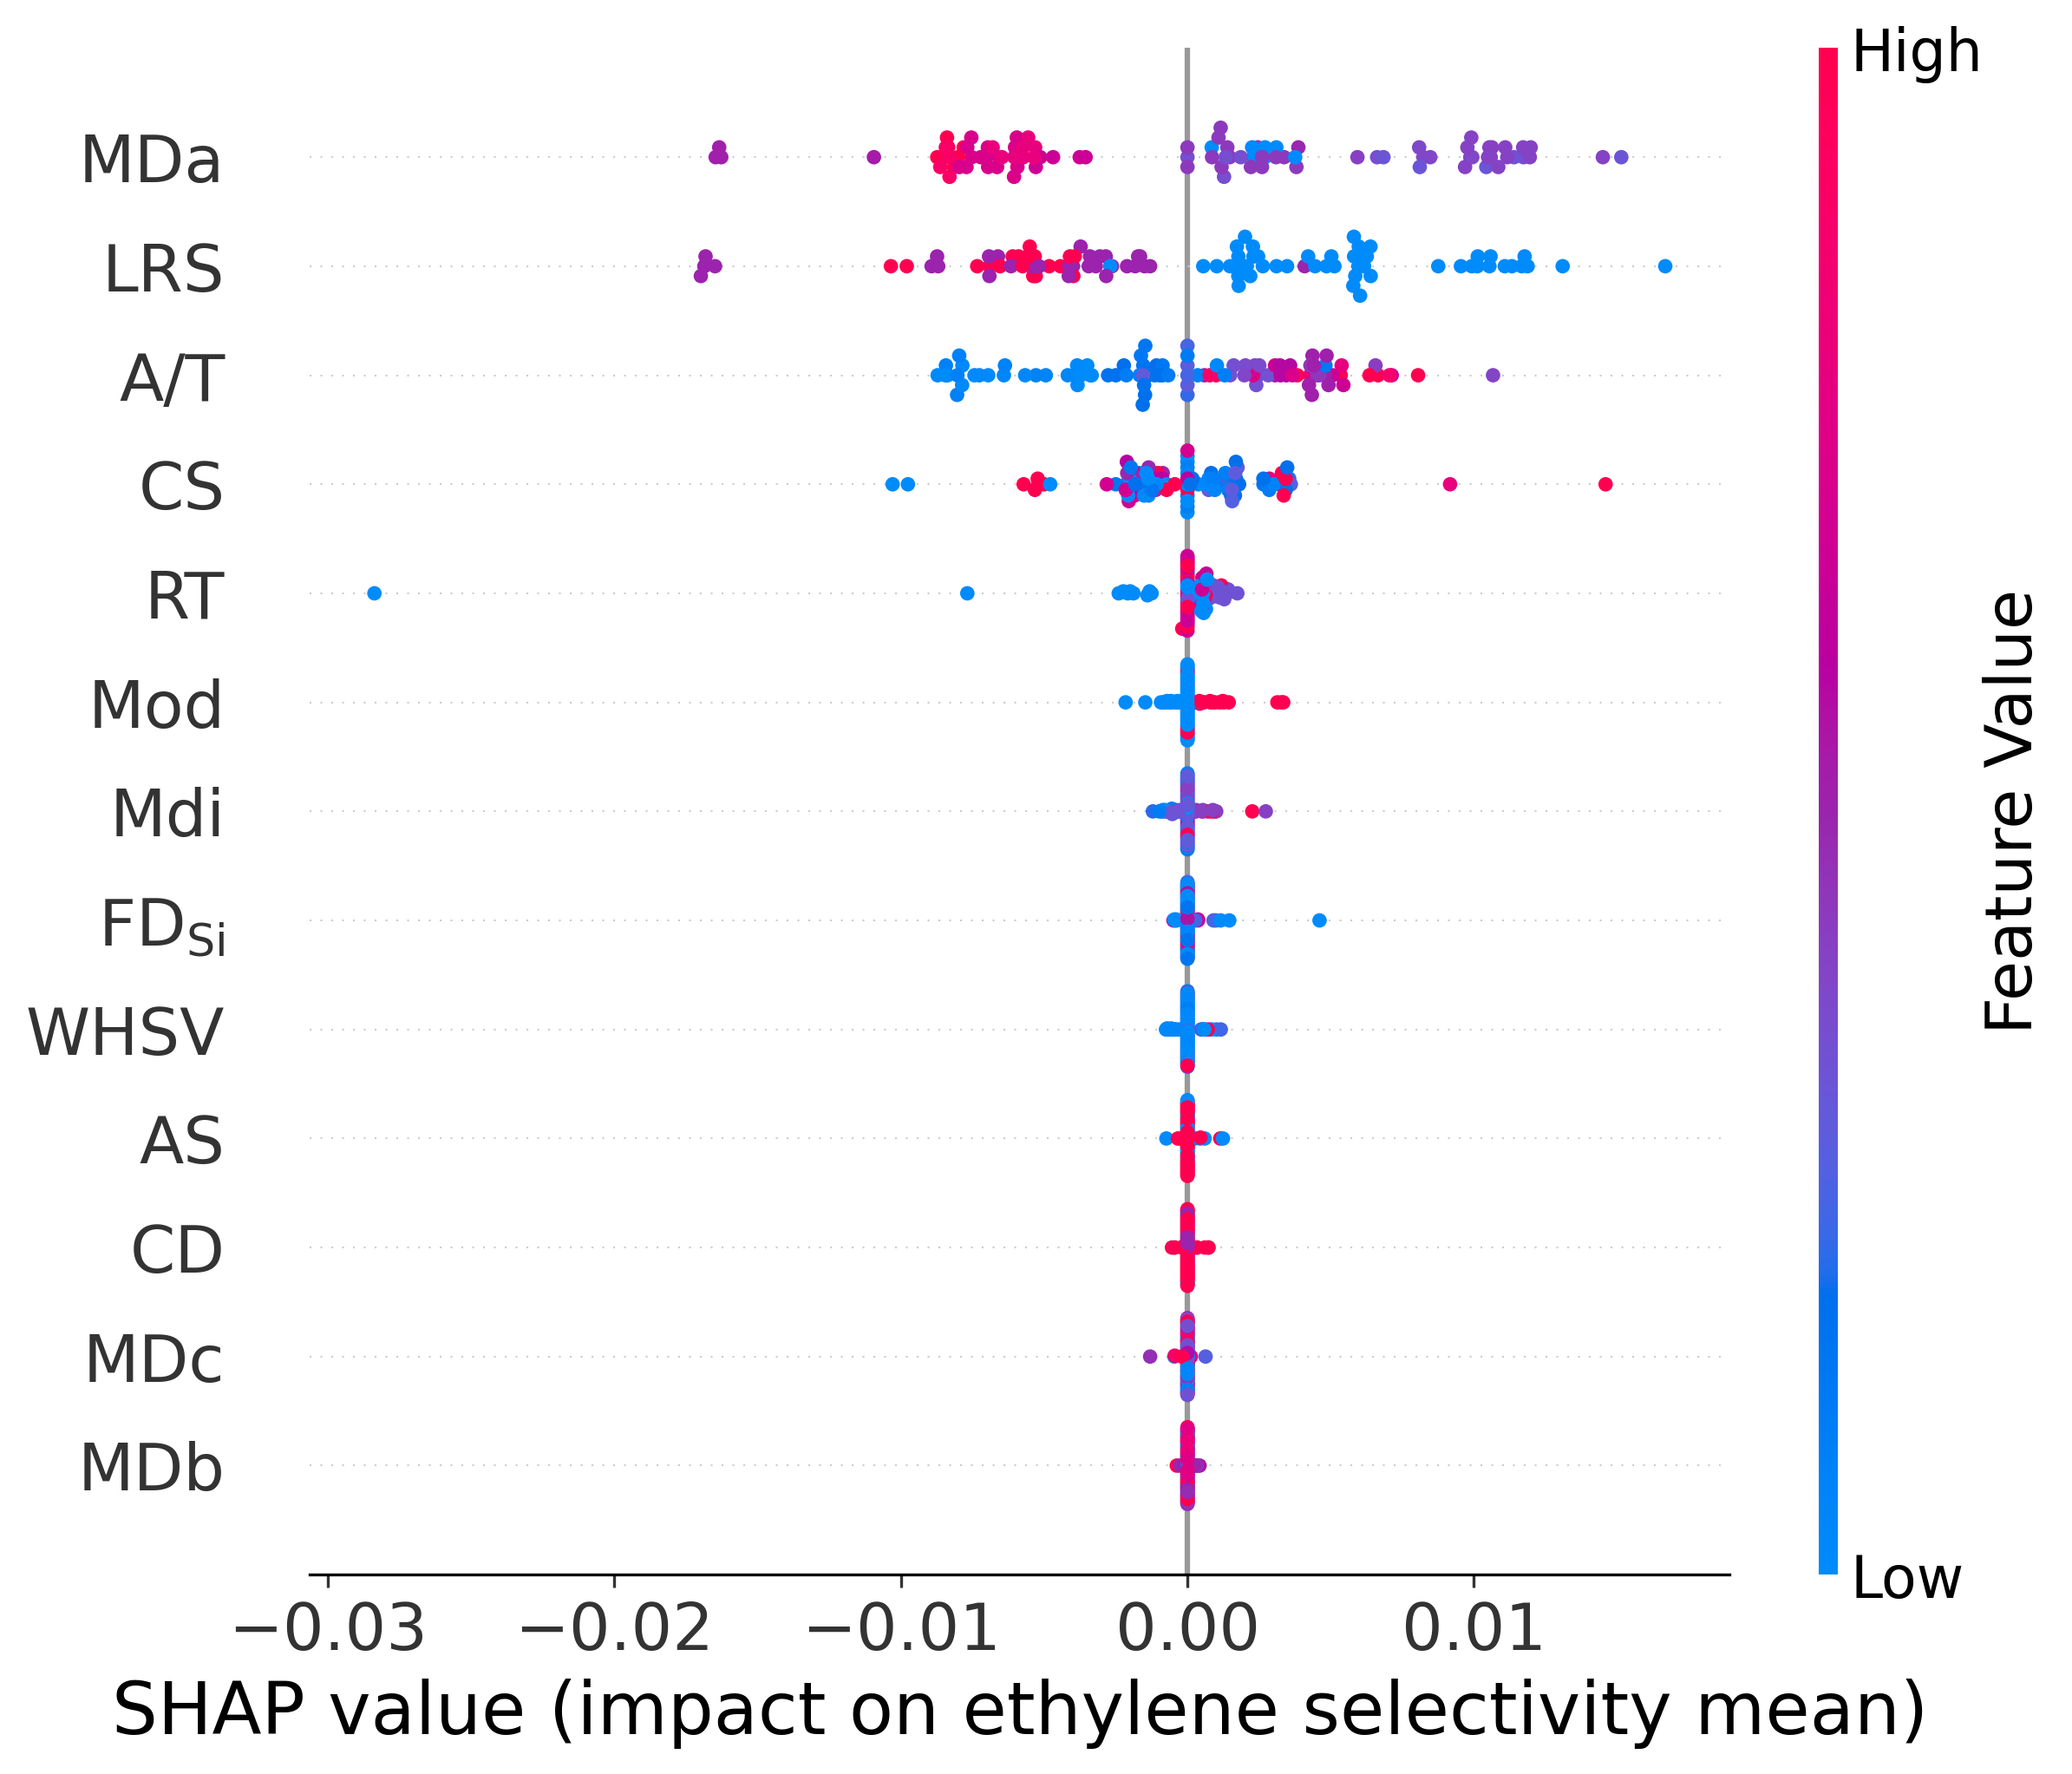

In [39]:
import shap
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(10, 8), dpi=300)
shap_s = shap.summary_plot(shap_values=shap_values, features = data_x, show=False)
axs.tick_params(axis='x', labelsize=18)
axs.tick_params(axis='y', labelsize=18)
axs.set_xlabel('SHAP value (impact on ethylene selectivity mean)', fontsize=20)
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=16)
cbar.set_ylabel('Feature Value', fontsize=18)
plt.savefig('figs/shap_s.png',bbox_inches='tight')

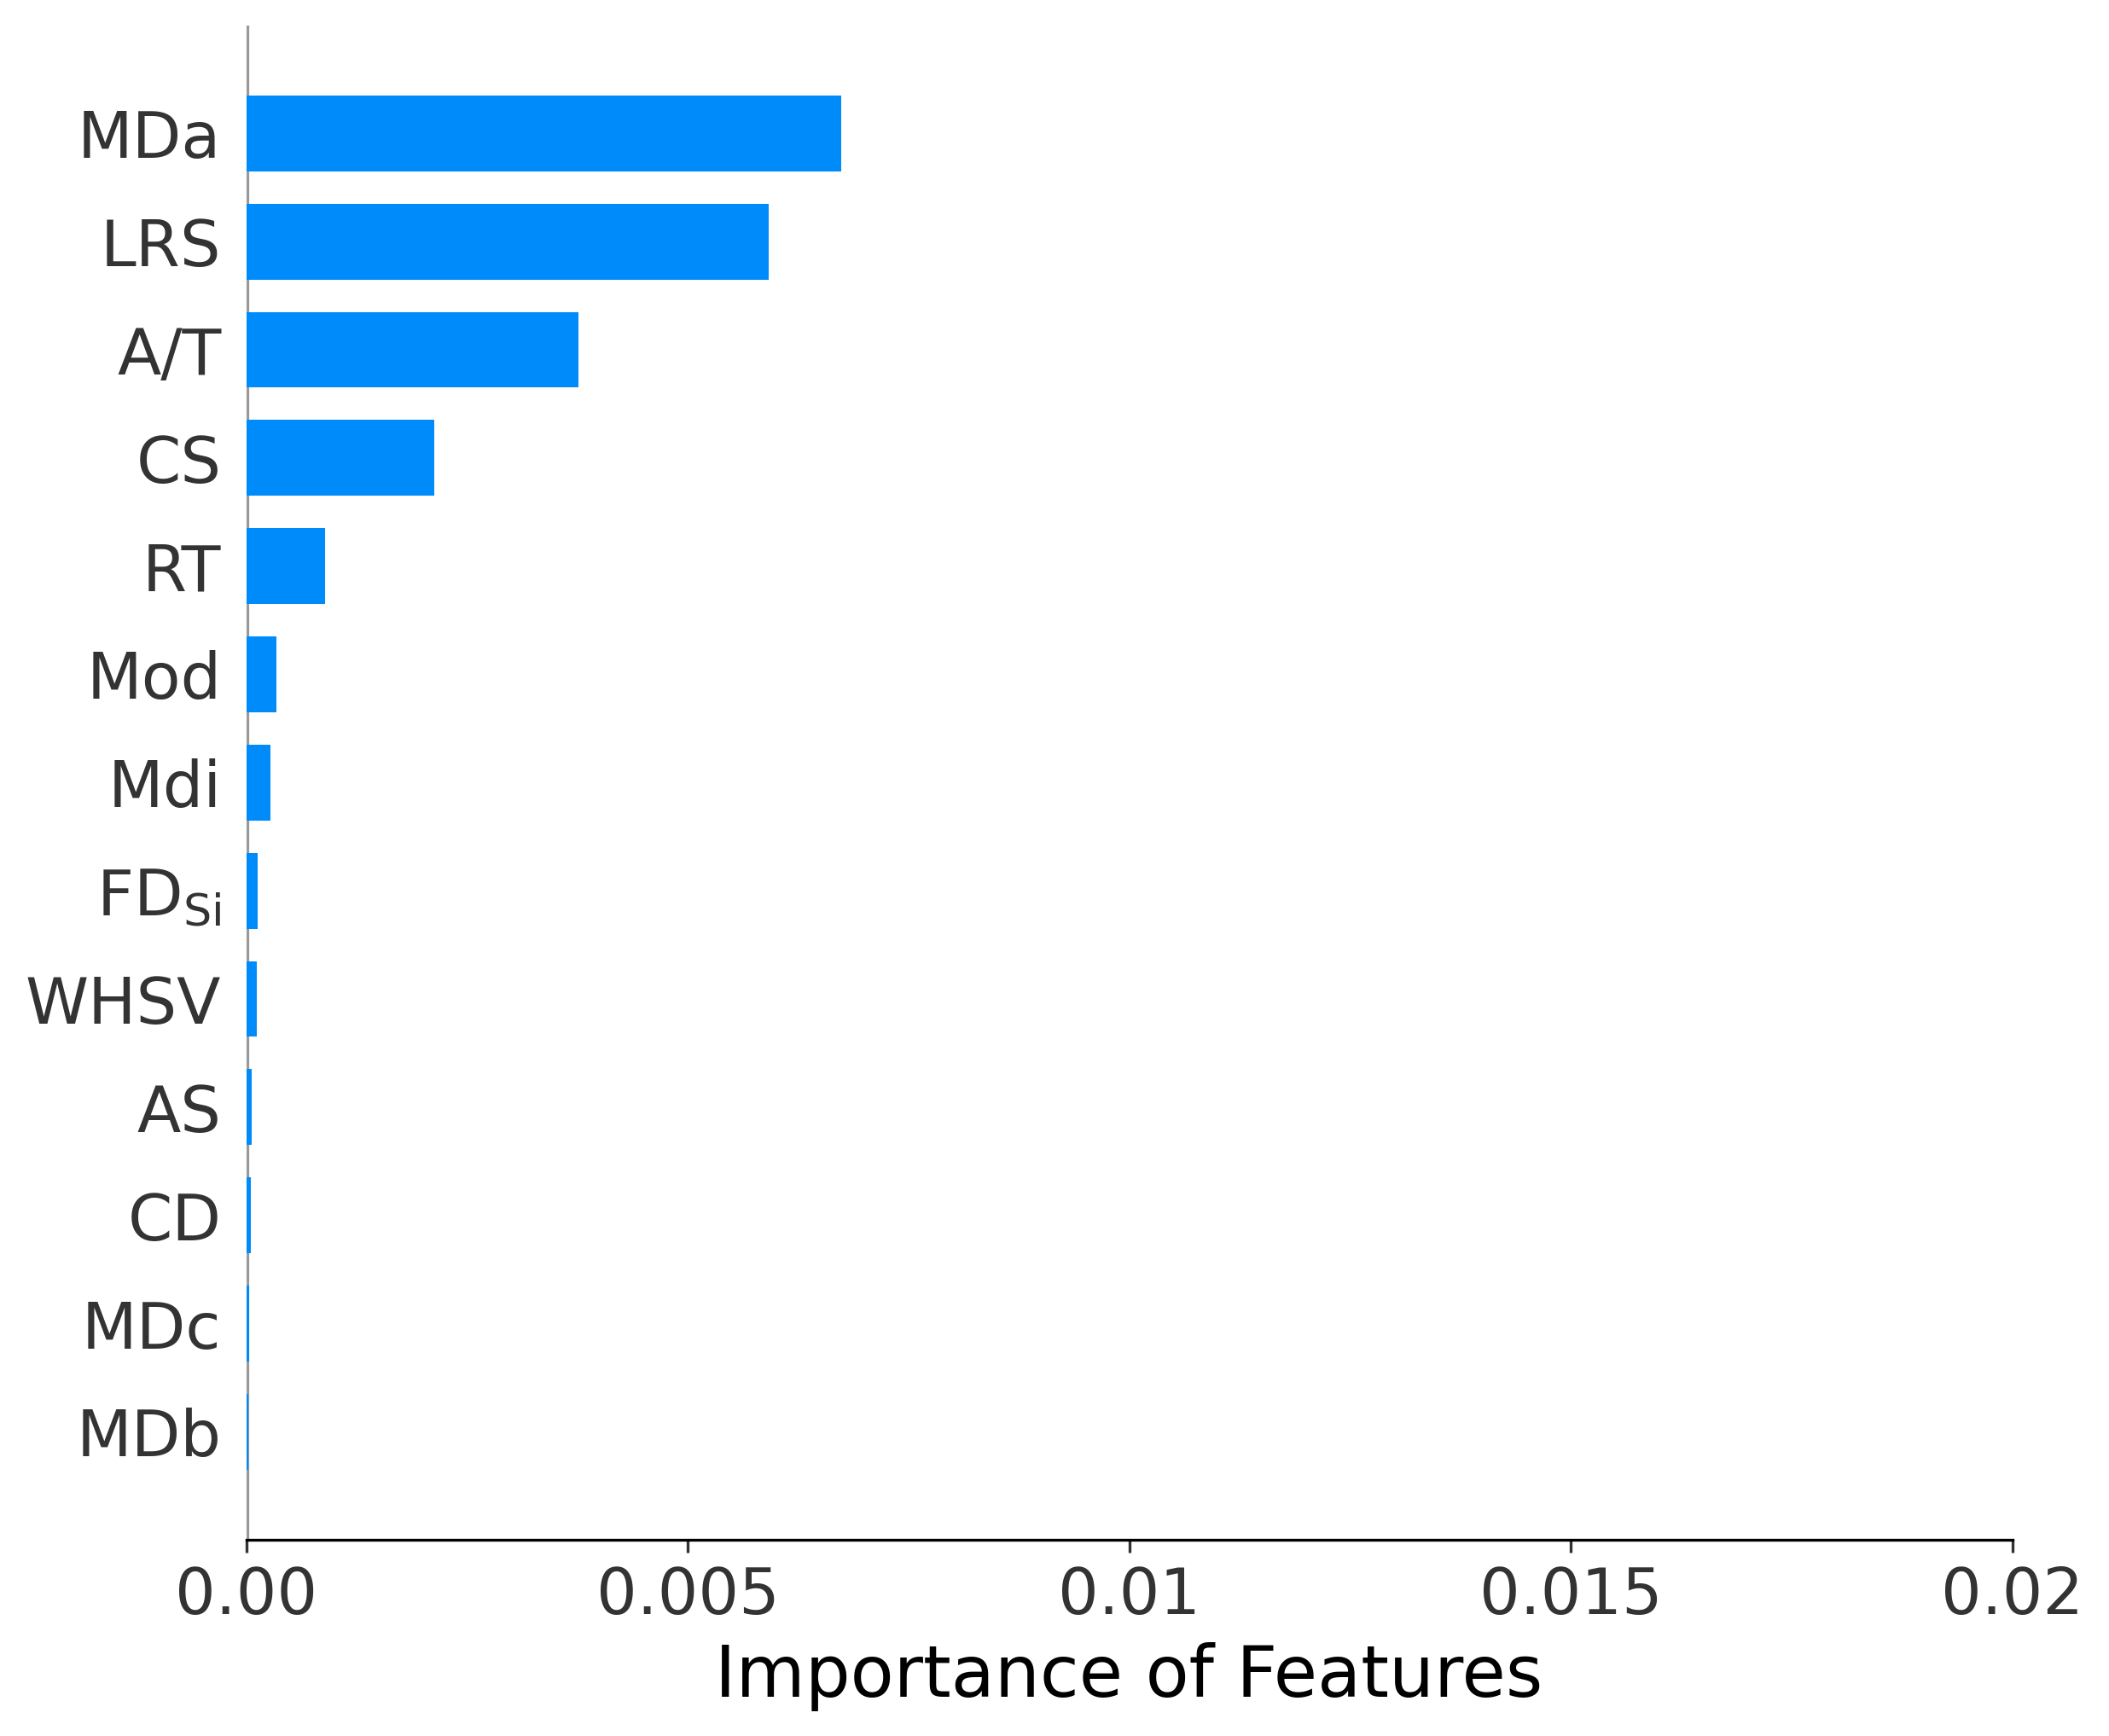

In [40]:
fig, axs = plt.subplots(figsize=(10, 8), dpi=300)
shap.summary_plot(shap_values=shap_values, features = data_x, plot_type="bar", show=False)
axs.tick_params(axis='x', labelsize=18)
axs.tick_params(axis='y', labelsize=18)
axs.set_xlabel('Importance of Features', fontsize=20)
desired_ticks = [0.00, 0.005, 0.01, 0.015, 0.02]
axs.set_xticks(desired_ticks)
axs.set_xticklabels(['0.00', '0.005', '0.01', '0.015', '0.02'])
plt.savefig('figs/shap_b.png',bbox_inches='tight')